# Training regression models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/1.intro-regression-training-cars.ipynb)

By [Terence Parr](https://explained.ai).

In this notebook, we're going to load the toy cars data set and train regression models to predict miles per gallon (MPG) through a variety of techniques. We start out doing a brute force grid search of many different slope and intercept (m, b) model parameters, looking for the best fit. Then we manually compute partial derivatives of the loss function and perform gradient descent using plain numpy. We look at the effect on the loss function of normalizing numeric variables to have zero mean and standard deviation one. Finally, this notebook shows you how to use the autograd (auto differentiation) functionality of pytorch as a way to transition from numpy to pytorch training loops.

## Support code

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import colors

In [2]:
def carshow(m, b, X, y, xcol='WGT', file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel(f"{xcol} (Standardized)")
    else:
        ax.set_xlabel(xcol)
    ax.set_ylabel("MPG")

    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    
    plt.show()

In [3]:
def mse(X,y,m,b):
    y_pred = m * X + b
#     return mean_squared_error(y, y_pred)
    return np.mean((y.reshape(-1,1)-y_pred.reshape(-1,1))**2)

def linmodel_coeff(X,y):
    lm = LinearRegression(normalize=False, fit_intercept=True)
    lm.fit(X, y)
#     print(lm.intercept_, lm.coef_)
    b = lm.intercept_[0]
    m = lm.coef_[0][0]
    return m,b

def grid_pairs(mrange, brange, n=100):
    pairs = [(m,b) for m in np.linspace(*mrange,num=n)
                   for b in np.linspace(*brange,num=n)]
    return np.array(pairs)

def loss_plot(m, b, z, truth=None, zmax=None, ax=None):
    cmap = plt.get_cmap('coolwarm')
    if zmax is not None:
        z = np.clip(z,min(z),zmax)
    norm = colors.Normalize(min(z),max(z))
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))
    if truth:
        tm,tb = truth
        ax.plot(tm, tb, 'x', ms=10, c='k')
    ax.scatter(m, b, s=30, c=cmap(norm(z)), alpha=1, marker='s')
    ax.set_xlabel("Slope m")
    ax.set_ylabel("Y-intercept b")
    ax.set_title("MSE linear model loss function")

def show(X, y, m, b, ax=None, xcol='WGT', file=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel(f"{xcol} (Standardized)")
    else:
        ax.set_xlabel(xcol)
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")

def explain(X, y, mrange, brange, normalize=False, zmax=None, file=None):
    if normalize:
        X = (X-np.mean(X))/np.std(X)

    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    m,b = linmodel_coeff(X,y)
    print(m,b,mse(X,y,m,b))
#     print(f"m = {m:.2f}, b = {b:.2f}")    
    pairs = grid_pairs(mrange, brange, n=50)
    z = np.array([mse(X,y,*pair) for pair in pairs])
    loss_plot(pairs[:,0], pairs[:,1], z, truth=(m,b), ax=axes[0], zmax=zmax)
    show(X, y, m, b, ax=axes[1], file=file)

## Load simple data set

You need to download cars.csv and put into a `data` subdirectory:

In [4]:
! mkdir -p data
! curl --silent https://raw.githubusercontent.com/parrt/fundamentals-of-deep-learning/main/notebooks/data/cars.csv > data/cars.csv

In [5]:
df_cars = pd.read_csv("data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


## Brute force grid search

Our model is a function of slope $m$ and $y$-intercept $b$ so in a sense finding the optimal model means searching the two-dimensional ($m$,$b$) spacelooking for the parameters (coordinates) that give the most accurate line through our data. The most accurate line is the one that has the lowest error, which we can define as the mean squared error between the predicted $\hat{y}$ and known true $y$. The naive but obvious approach is simply to compute the error for all possible ($m$,$b$) coordinates in search space, so let's see what that looks like.

### Visualizing search space (loss function)

Here's what a typical linear regression search space looks like with colors representing loss function values where red is higher loss and blue is lower (this is actually copied from a different regression problem):

<img src="images/2d-loss.png" width="200">

Sometimes it's easier to understand a 2D projection and here is the 2D projection of the loss function for this particular regression problem.

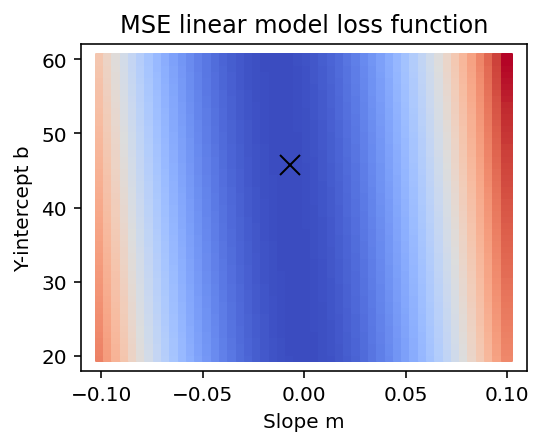

In [6]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
y = np.array(df_cars.MPG).reshape(n,1)
mrange = (-.1,.1)
brange = (20,60)
pairs = grid_pairs(mrange, brange, n=50)
z = np.array([mse(X,y,*pair) for pair in pairs])
m=-0.007 # best coordinates
b=45.75
loss_plot(pairs[:,0], pairs[:,1], z, truth=(m,b), zmax=None)

### Searching (m,b) space

Naturally a brute force is absurdly slow and only works when we have a few parameters like this. Still, we need to choose the search space carefully so it doesn't take forever.

In [7]:
# brute force model parameter space search (m,b)
best = (1e100,0,0)
for m in np.linspace(-0.005,-.01,num=5):
    for b in np.linspace(42,47,num=5):
        y = m * df_cars.WGT + b
        loss = np.mean((y - df_cars.MPG)**2) # MSE
        if loss < best[0]:
            best = (loss,m,b)
        print(f"{m:4.3f},{b:4.3f} => MSE {loss:.1f}")
m = best[1]
b = best[2]
print(f"BEST {m:.3f}*x + {b:.3f}")

-0.005,42.000 => MSE 37.2
-0.005,43.250 => MSE 47.9
-0.005,44.500 => MSE 61.7
-0.005,45.750 => MSE 78.7
-0.005,47.000 => MSE 98.8
-0.006,42.000 => MSE 20.1
-0.006,43.250 => MSE 21.5
-0.006,44.500 => MSE 26.1
-0.006,45.750 => MSE 33.7
-0.006,47.000 => MSE 44.5
-0.007,42.000 => MSE 33.0
-0.007,43.250 => MSE 25.1
-0.007,44.500 => MSE 20.3
-0.007,45.750 => MSE 18.7
-0.007,47.000 => MSE 20.2
-0.009,42.000 => MSE 75.8
-0.009,43.250 => MSE 58.6
-0.009,44.500 => MSE 44.5
-0.009,45.750 => MSE 33.6
-0.009,47.000 => MSE 25.8
-0.010,42.000 => MSE 148.6
-0.010,43.250 => MSE 122.1
-0.010,44.500 => MSE 98.7
-0.010,45.750 => MSE 78.5
-0.010,47.000 => MSE 61.4
BEST -0.007*x + 45.750


Using the discovered parameters, m=-0.007 and b=45.75, we can draw a line through the data.

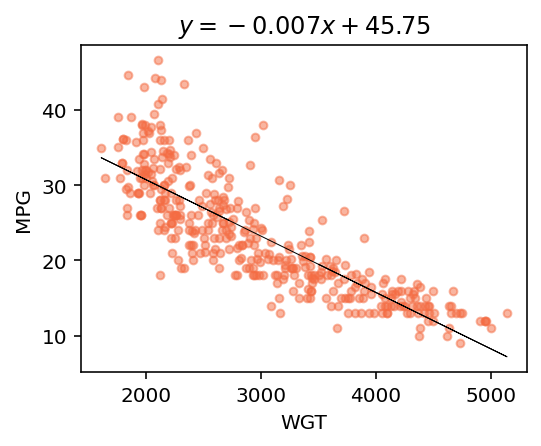

In [8]:
carshow(m, b, X=df_cars.WGT, y=df_cars.MPG)

## Manual gradient computation of loss function with numpy

We don't have to do a brute force search because we can use information obtained from the loss function in the neighborhood of the current search position in order to move in the direction of lower loss.  The slope of the loss function in any direction points upward for that direction, so if we move in the negative of the slope direction, we are heading downhill (to lower cost).  If we compute the negative slope for all directions, each parameter, then we have a gradient vector that points towards lower cost.  Then we just have to take a small step in that direction to lower the cost. We keep doing this until the gradient goes to zero, meaning the loss function is flat and we are at a minimum, or until we get tired of waiting for convergence.

Because were using the mean squared error, a simple quadratic, we know that the derivative exists and is smooth; moreover it has a single  minimum at the optimal coordinates.  With a little bit of derivative calculus, we can compute the slope (derivative) of the loss function with respect to each model parameter. The loss function is:
 
$$
loss = \sum_i^n E^2 \text{ where } E = \hat{y} - y = mx + b - y
$$

(use the sum, ignoring $1/n$ constant.) Loss function is a saddle like this:

<img src="images/2d-loss.png" width="200">

The derivatives in each direction, the so-called partial derivatives, are:

$$
\begin{array}{rcl}
\frac{\partial}{\partial m} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial m}\\
 & = & \sum_i^n E x\\
\end{array}
$$

$$
\begin{array}{rcl}
\frac{\partial}{\partial b} loss & = & \sum_i^n E^2\\
 & = & 2 \sum_i^n E \frac{\partial E}{\partial b}\\
 & = & \sum_i^n E\\
\end{array}
$$

Instead of a brute force search of the parameter space, let's alter our parameter search loop so that it adjusts the model parameters towards lower loss at each step. We will do this for `nepochs` iterations:

Epoch     0  0.004,35.00: MSE loss     648.4835 MAE  23.1534
Epoch    10 -0.003,35.00: MSE loss      37.7837 MAE   5.2777
Epoch    20 -0.004,35.00: MSE loss      28.2723 MAE   4.1416
Epoch    30 -0.004,35.00: MSE loss      28.1242 MAE   4.0393
Epoch    40 -0.004,35.00: MSE loss      28.1219 MAE   4.0282
Epoch    50 -0.004,35.00: MSE loss      28.1219 MAE   4.0269
Epoch    60 -0.004,35.00: MSE loss      28.1219 MAE   4.0267
Epoch    70 -0.004,35.00: MSE loss      28.1219 MAE   4.0267
Epoch    80 -0.004,35.00: MSE loss      28.1219 MAE   4.0267
Epoch    90 -0.004,35.00: MSE loss      28.1219 MAE   4.0267
Epoch   100 -0.004,35.00: MSE loss      28.1219 MAE   4.0267
LAST        -0.004,35.000: MSE loss      28.1219 MAE   4.0267


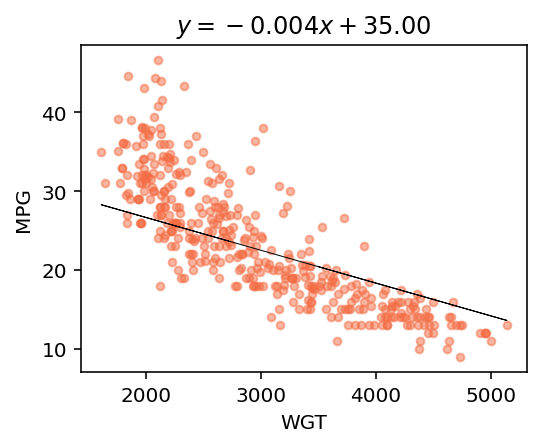

In [9]:
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
y = np.array(df_cars.MPG).reshape(n,1)

# Randomly initialize slope
m = np.random.random(size=1)[0]
b = 35.0 # get it close to final answer or it takes forever to get there
# Loss surface is a valley; explodes if this learning rate is much bigger
learning_rate = .00000000005 # almost too fast for m, but incredibly slow for b.
nepochs=100
for epoch in range(nepochs+1):
    y_pred = m * X + b
    E = y_pred - y
    loss = np.mean(E**2)
    if epoch % 10 == 0:
        mae = np.mean(np.abs(y_pred - y))
        print(f"Epoch {epoch:5d} {m:6.3f},{b:4.2f}: MSE loss {loss:12.4f} MAE {mae:8.4f}")

    # Compute the gradient of loss with respect to m, b
    m_grad = np.sum(E * X) # From the symbolic gradient math computed above
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:6.3f},{b:6.3f}: MSE loss {loss:12.4f} MAE {mae:8.4f}")
carshow(m, b, X, y, file="lin")

#### Exercise

Change the starting value of the y-intercept, `b`, to be 5 and rerun that loop. What happens and why?

<details>
<summary>Solution</summary>
    We get a terrible solution for the best fit line. The learning rate is so small that there's no way to make progress moving parameter `b` towards the proper value.
</details>

Given the number of iterations and the learning rate hyper parameter, we don't get the exact answer, but we can easily fix that by normalizing the X features.

## Standardized/normalized variables

Standardizing variables to be mean centered and with standard deviation one, improves convergence speed. Previously we had to choose a `b` that was very close to the answer so that training converged at a reasonable pace.  A single learning rate cannot deal with loss functions that are radically different in different dimensions.

The old but very useful article [Efficient BackProp by LeCun et al](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), describes why we need to standardize our X variables. I'm under the impression that getting all of the variances to 1.0 or at least similar, means we don't need learning rates per dimension (variable). The article indicates that we want the zero mean because "*any shift of the average input away from zero will bias the updates in a particular direction and thus slow down learning.*"  Consider the input layer to a network. We saw above that the derivative of the loss with respect to the $m$ slope parameter is the error, $E = y-\hat{y}$, times the $x_i$ input for variable $i$. LeCun points out that, if all inputs are positive, the $sign(E)$ dictates the direction we update the $m$ slopes. "*... these weights [$m$] can only all decrease or all increase together for a given input pattern. Thus, if a weight vector must change direction it can only do so by zigzagging which is inefficient and thus very slow.*"

To see how much easier it is to train our linear model using standardization, let's first plot the loss function for our cars data with respect to model parameters `m` and `b` and show the best fit line obtained from sklearn's `LinearRegression`:

-0.00764734245858457 46.21652431150987 18.676616404930005


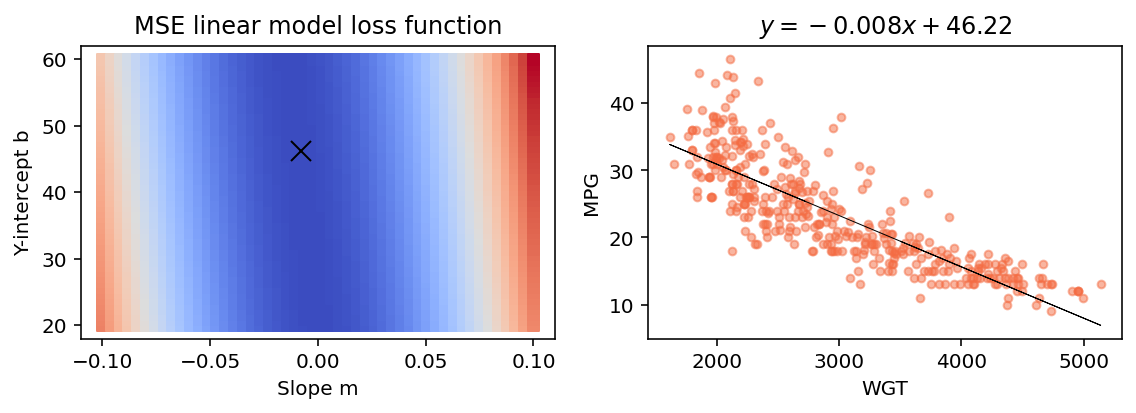

In [10]:
X = np.array(df_cars.WGT).reshape(n,1)
y = np.array(df_cars.MPG).reshape(n,1)
explain(X, y, mrange = (-.1,.1), brange = (20,60), zmax=None, file="cars")

The loss function is a shallow valley, almost flat in the `b` dimension. That requires a huge learning rate to make any progress whereas the other dimension is fairly steep and needs a smaller learning rate to avoid diverging. Take a look at the loss function after we normalize the features:

-6.487381674854015 23.445918359693877 18.67661640493001


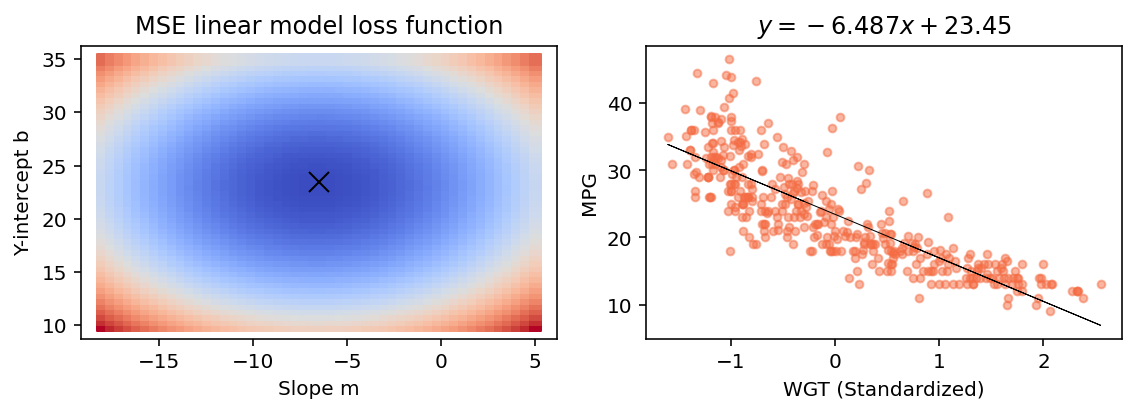

In [11]:
explain(X, y,
        mrange = (-18,5), brange = (10,35),
        normalize=True,
        file="cars-norm")

### Training loop using randomized parameter starting locations

Let's look at the training loop again but this time noticed that we have a much larger learning rate and we can start the model parameters anywhere we want. (We're still using the symbolic gradients that we derived manually to drive the gradient descent.)

In [12]:
# Normalize variables
n = len(df_cars)
X = np.array(df_cars.WGT).reshape(n,1)
X = (X-np.mean(X))/np.std(X)
y = np.array(df_cars.MPG).reshape(n,1)

Epoch     0  0.430, 0.492: MSE loss      593.388 MAE    22.95
Epoch     1 -4.993,18.488: MSE loss       45.490 MAE     5.21
Epoch     2 -6.165,22.375: MSE loss       19.928 MAE     3.30
Epoch     3 -6.418,23.215: MSE loss       18.735 MAE     3.26
Epoch     4 -6.472,23.396: MSE loss       18.679 MAE     3.27
Epoch     5 -6.484,23.435: MSE loss       18.677 MAE     3.28
Epoch     6 -6.487,23.444: MSE loss       18.677 MAE     3.28
Epoch     7 -6.487,23.445: MSE loss       18.677 MAE     3.28
Epoch     8 -6.487,23.446: MSE loss       18.677 MAE     3.28
Epoch     9 -6.487,23.446: MSE loss       18.677 MAE     3.28
Epoch    10 -6.487,23.446: MSE loss       18.677 MAE     3.28
LAST        -6.487,23.446: MSE loss       18.677 MAE     3.28


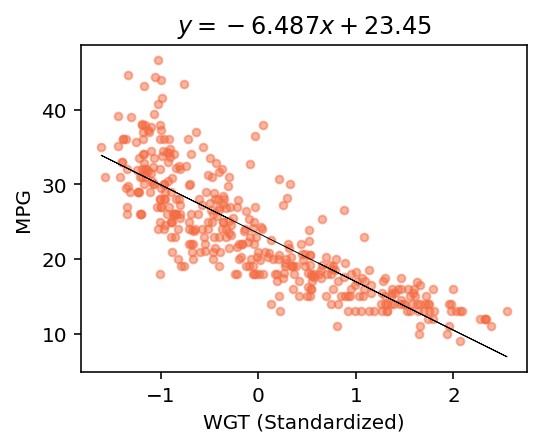

In [13]:
# Randomly initialize slope and y-intercept
m = np.random.random(size=1)[0]
b = np.random.random(size=1)[0]
learning_rate = .002 # learning rate is much faster for normalized variables
nepochs=10           # needs many fewer iterations
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    E = y_pred - y
    loss = np.mean(E**2)
    mae = np.mean(np.abs(y_pred - y))
    print(f"Epoch {epoch:5d} {m:6.3f},{b:6.3f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    m_grad = np.sum(E * X)
    b_grad = np.sum(E)
    
    m = m - learning_rate * m_grad
    b = b - learning_rate * b_grad
    
print(f"LAST        {m:6.3f},{b:6.3f}: MSE loss {loss:12.3f} MAE {mae:8.2f}")
carshow(m, b, X=X, y=df_cars.MPG)

## Training regressor using pytorch's autograd

For more complicated models, it's too painful and error-prone to manually compute our own symbolic derivatives. Fortunately, PyTorch will do this automatically for us, but it means switching to a new library.  You can think of PyTorch as a numpy-like library that knows how to execute matrix arithmetic on GPUs (to exploit the massive amount of parallelism they provide).

In [14]:
# Normalize and get into PyTorch tensors (n-dimensional arrays)
n = len(df_cars)
X = torch.tensor(df_cars.WGT).reshape(n,1).float()
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

The training loop is exactly the same except for the library change and how we compute the gradients. Previously we took the derivative symbolically and then implemented it as code (using numpy):

```python
E = y_pred - y
...
m_grad = np.sum(E * X) # symbolic derivative of loss with respect to m
b_grad = np.sum(E)     # symbolic derivative of loss with respect to b
```

Now, we can just compute the loss using Python and ask pytorch to compute the derivative based upon the loss computation, all using a single call to `loss.backward()`! Any tensor (with `requires_grad=True` set) involved in the computation will automatically get is `grad` field set as the gradient of that variable with respect to the computation.

```python
# After this call m.grad and b.grad will be Variables holding the gradient
# of the loss with respect to m and b respectively
loss = torch.mean((y_pred - y)**2)
loss.backward()        # compute the derivative of loss with respect to all variables
```

To update the model parameters, we previously did

```python
m -= learning_rate * m_grad
b -= learning_rate * b_grad
```

and we will do the exact same thing again, with the caveat that we have to tell pytorch not to use or track these computations when computing gradients.

```python
with torch.no_grad():
    m -= learning_rate * m.grad
    b -= learning_rate * b.grad

# Zero the gradients in preparation for next iteration
m.grad.zero_()
b.grad.zero_()
```

Side-by-side, here are the changes:

<img src="images/numpy_to_pytorch.png" width="600">

Here's the full loop:

Epoch     0 -0.689, 1.248: MSE loss  545.037 MAE  22.20
Epoch     1 -4.164,14.567: MSE loss  102.936 MAE   8.89
Epoch     2 -5.560,19.894: MSE loss   32.165 MAE   4.22
Epoch     3 -6.120,22.025: MSE loss   20.836 MAE   3.35
Epoch     4 -6.345,22.878: MSE loss   19.022 MAE   3.26
Epoch     5 -6.435,23.219: MSE loss   18.732 MAE   3.26
Epoch     6 -6.471,23.355: MSE loss   18.685 MAE   3.27
Epoch     7 -6.486,23.410: MSE loss   18.678 MAE   3.28
Epoch     8 -6.492,23.431: MSE loss   18.677 MAE   3.28
Epoch     9 -6.494,23.440: MSE loss   18.677 MAE   3.28
Epoch    10 -6.495,23.444: MSE loss   18.677 MAE   3.28
LAST        -6.50,23.44: MSE loss   18.677 MAE   3.28


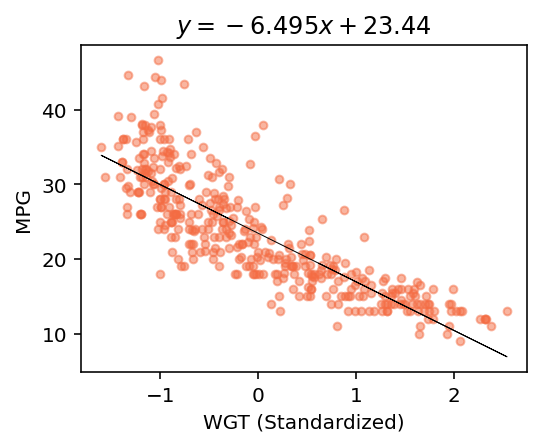

In [15]:
# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)  # <-- track for autograd
b = torch.randn(1, 1, requires_grad=True) # too far away from correct answer for one learning rate
learning_rate = .3
nepochs=10
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - y)**2)
    with torch.no_grad():
        mae = torch.mean(torch.abs(y_pred - y))
        print(f"Epoch {epoch:5d} {m.detach().item():6.3f},{b.detach().item():6.3f}: MSE loss {loss:8.3f} MAE {mae:6.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call m.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update m and b using gradient descent; m.data and b.data are Tensors,
    # m.grad and b.grad are Variables and m.grad.data and b.grad.data are Tensors
    with torch.no_grad():
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
#     print(m.detach().item(), b.detach().item())
    # Zero the gradients
    m.grad.zero_()
    b.grad.zero_()

m = m.detach().item()
b = b.detach().item()
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:8.3f} MAE {mae:6.2f}")
carshow(m, b, X=X, y=df_cars.MPG)

#### Exercise

Reuse the code of the training loop to train a model (with pytorch) for `ENG` $\rightarrow$ `MPG`, instead of `WGT` $\rightarrow$ `MPG`. Hint: You can pass `xcol='ENG'` to `carshow()` to show the proper variables.

<details>
<summary>Solution</summary>

<pre>
n = len(df_cars)
X = torch.tensor(df_cars.ENG).reshape(n,1).float()  # solution changed this line
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

# Randomly initialize weights
m = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, 1, requires_grad=True)
learning_rate = .3
nepochs=10
for epoch in range(nepochs+1):
    # Forward pass over all x,y pairs: compute predicted y
    y_pred = m * X + b
    loss = torch.mean((y_pred - y)**2)
    with torch.no_grad():
        mae = torch.mean(torch.abs(y_pred - y))
        print(f"Epoch {epoch:5d} {m.detach().item():6.3f},{b.detach().item():6.3f}: MSE loss {loss:8.3f} MAE {mae:6.2f}")

    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call m.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update m and b using gradient descent; m.data and b.data are Tensors,
    # m.grad and b.grad are Variables and m.grad.data and b.grad.data are Tensors
    with torch.no_grad():
        m -= learning_rate * m.grad
        b -= learning_rate * b.grad
    
    # Zero the gradients
    m.grad.zero_()
    b.grad.zero_()

m = m.detach().item()
b = b.detach().item()
print(f"LAST        {m:4.2f},{b:4.2f}: MSE loss {loss:8.3f} MAE {mae:6.2f}")
carshow(m, b, X=X, y=df_cars.MPG, xcol='ENG')   # solution changed this line

</pre>
</details>

#### Exercise

Why do the linear models for both `WGT` $\rightarrow$ `MPG` and `ENG` $\rightarrow$ `MPG` have the same b=23.44 y-intercept? Is that value special?

<details>
<summary>Solution</summary>
    Yes, the value is $\bar{y}$, <tt>torch.mean(y)</tt>. For normalized $X$ variables, the y-intercept $\beta_0$ is the mean of $y$ for linear regression with the mean squared error loss function.
</details>